# A. Project Description

**Student ID:** 25506751  
**Title:** AT2 — Combined Experiments (1) Rain-or-Not (+7 days) & (2) Precipitation Fall (next 3 days)

**Short description:** This notebook follows the client template A–H. It loads the provided dataset, prepares features, defines two targets (classification: `will_rain_plus7`, regression: `precip_next_3days`), performs EDA, feature selection, transformation, trains/evaluates models for both experiments, saves prepared datasets and model artifacts, and summarizes outcomes.

---

# B. Business Understanding

- **Objective 1 (Classification):** Predict whether it will rain within +7 days (`will_rain_plus7`) — binary classification useful for alerting and planning.
- **Objective 2 (Regression):** Predict total precipitation over the next 3 days (`precip_next_3days`) — numeric forecast for resource planning.
- **Success criteria:** For classification — AUC ≥ 0.7 is a useful baseline; for regression — MAE/RMSE as low as possible and R² positive; final decision depends on client thresholds.

---

# C. Data Understanding

## C.1 Load Datasets


In [21]:

# If you run on a fresh environment uncomment this:
%pip install -q pandas numpy matplotlib seaborn scikit-learn joblib

import os
import pandas as pd
import numpy as np

# attempt multiple likely locations for dataset.csv
candidates = [
    "notebooks/dataset.csv",
    "./notebooks/dataset.csv",
    "dataset.csv",
    "../notebooks/dataset.csv",
    "AT2_EXP-main/notebooks/dataset.csv"
]
DATA_PATH = None
for p in candidates:
    if os.path.exists(p):
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        "dataset.csv not found. Put it in notebooks/ or the same folder as this notebook, or set DATA_PATH."
    )

df = pd.read_csv(DATA_PATH, parse_dates=["date"])
print("Loaded:", DATA_PATH)
print("Rows, cols:", df.shape)
df.head()

Note: you may need to restart the kernel to use updated packages.
Loaded: dataset.csv
Rows, cols: (358, 12)


,date,dayofyear_sin,dayofyear_cos,precip_last_1,precip_last_3,precip_last_7,temp_max_mean_7,temp_min_mean_7,precip_hours_last_7,weathercode,will_rain_plus7,precip_next_3days
0,2023-01-01,0.017202,0.999852,10.293861,10.293861,10.293861,18.529584,5.323336,6,61,0,16.87
1,2023-01-02,0.034398,0.999408,0.000000,10.293861,10.293861,17.167908,4.973973,6,80,0,21.43
2,2023-01-03,0.051584,0.998669,13.354692,23.648553,23.648553,17.102202,4.723854,13,1,0,17.36
3,2023-01-04,0.068755,0.997634,3.516915,16.871607,27.165467,17.703014,4.664940,17,61,1,13.84
4,2023-01-05,0.085906,0.996303,4.557101,21.428708,31.722568,17.916828,4.288141,20,63,0,9.28


# C.2 Define Target variable
Targets present in dataset:
- `will_rain_plus7` : binary (0/1) — classification target.
- `precip_next_3days` : float — regression target.


# C.3 Create Target variable

In [22]:
# basic checks and ensure dtype consistency
print("will_rain_plus7 value counts:\n", df["will_rain_plus7"].value_counts(dropna=False))
print("\nprecip_next_3days summary:\n", df["precip_next_3days"].describe())

# If any NA in targets — drop for modeling (or impute if desired)
for t in ["will_rain_plus7", "precip_next_3days"]:
    n_na = df[t].isna().sum()
    if n_na > 0:
        print(f"Warning: target {t} has {n_na} missing — dropping those rows for modeling.")
        df = df.dropna(subset=[t])


will_rain_plus7 value counts:
 will_rain_plus7
0    282
1     76
Name: count, dtype: int64

precip_next_3days summary:
 count    358.000000
mean       4.713715
std        7.248979
min        0.000000
25%        0.000000
50%        0.280000
75%        7.502500
max       40.070000
Name: precip_next_3days, dtype: float64


# C.4 Explore Target variable

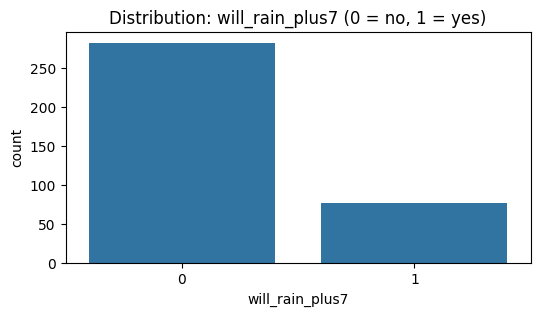

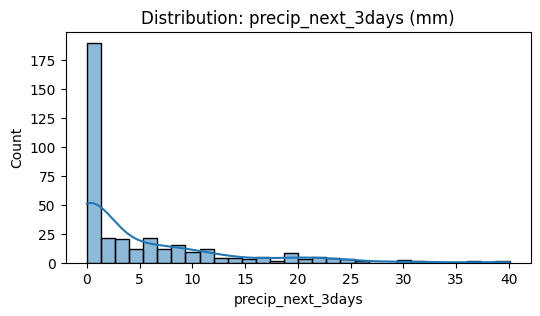

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# classification target distribution
plt.figure(figsize=(6,3))
sns.countplot(x="will_rain_plus7", data=df)
plt.title("Distribution: will_rain_plus7 (0 = no, 1 = yes)")
plt.show()

# regression target distribution
plt.figure(figsize=(6,3))
sns.histplot(df["precip_next_3days"], bins=30, kde=True)
plt.title("Distribution: precip_next_3days (mm)")
plt.show()


# C.5 Explore Feature of Interest — precipitation history

precip_next_3days      1.000000
precip_last_7          0.208316
precip_last_3          0.206300
precip_hours_last_7    0.188465
precip_last_1          0.104735
temp_max_mean_7       -0.419618
temp_min_mean_7       -0.420471
Name: precip_next_3days, dtype: float64


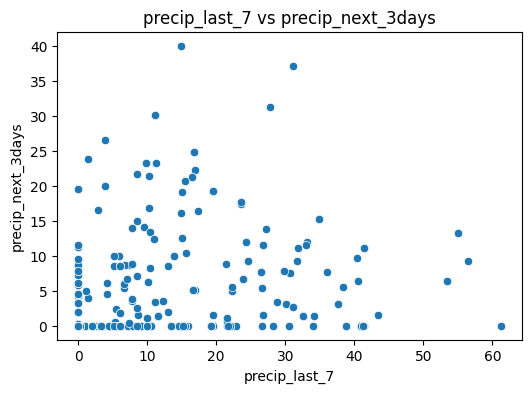

In [24]:
# quick correlation (regression target)
num_cols = [
    "precip_last_1","precip_last_3","precip_last_7",
    "temp_max_mean_7","temp_min_mean_7","precip_hours_last_7"
]
print(df[num_cols + ["precip_next_3days"]].corr()["precip_next_3days"].sort_values(ascending=False))

# visualize precip_last_7 vs precip_next_3days
plt.figure(figsize=(6,4))
sns.scatterplot(x="precip_last_7", y="precip_next_3days", data=df)
plt.title("precip_last_7 vs precip_next_3days")
plt.show()


# C.6 Explore Feature of Interest — weathercode and seasonality

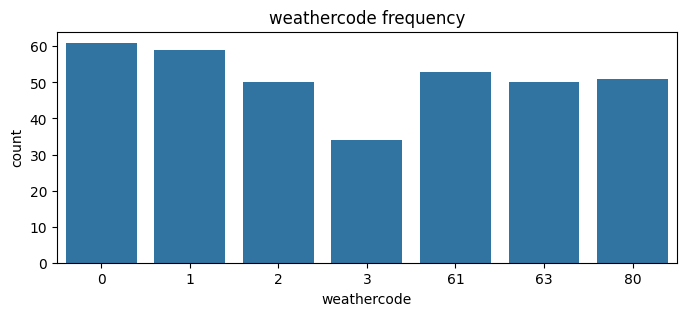

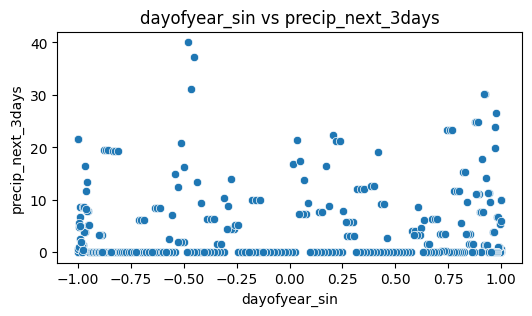

In [25]:
# weathercode counts
plt.figure(figsize=(8,3))
sns.countplot(x="weathercode", data=df)
plt.title("weathercode frequency")
plt.show()

# day-of-year cyclic features
plt.figure(figsize=(6,3))
sns.scatterplot(x="dayofyear_sin", y="precip_next_3days", data=df)
plt.title("dayofyear_sin vs precip_next_3days")
plt.show()


# D. Feature Selection

Approach: start with domain features provided in dataset. Compute:

* simple correlation (for regression)

* RandomForest feature importance (brief) for both tasks

In [26]:
# features originally used in experiments (keep consistent)
FEATURE_COLS = [
    "dayofyear_sin","dayofyear_cos",
    "precip_last_1","precip_last_3","precip_last_7",
    "temp_max_mean_7","temp_min_mean_7",
    "precip_hours_last_7","weathercode"
]
# ensure columns exist
FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]
print("Using features:", FEATURE_COLS)


Using features: ['dayofyear_sin', 'dayofyear_cos', 'precip_last_1', 'precip_last_3', 'precip_last_7', 'temp_max_mean_7', 'temp_min_mean_7', 'precip_hours_last_7', 'weathercode']


# D.1 Approach — correlation + RF importance (regression)

In [27]:
# correlation (numerical only)
corrs = df[FEATURE_COLS + ["precip_next_3days"]].select_dtypes(include=np.number).corr()
print("Top correlations with precip_next_3days:\n", corrs["precip_next_3days"].abs().sort_values(ascending=False).head(10))


Top correlations with precip_next_3days:
 precip_next_3days      1.000000
dayofyear_cos          0.421840
temp_min_mean_7        0.420471
temp_max_mean_7        0.419618
precip_last_7          0.208316
precip_last_3          0.206300
precip_hours_last_7    0.188465
precip_last_1          0.104735
dayofyear_sin          0.077350
weathercode            0.003418
Name: precip_next_3days, dtype: float64


# D.2 Approach — feature importance (classification & regression)

In [28]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

# prepare basic X (get_dummies for weathercode), minimal preprocessing
def prepare_X(df_in, features):
    X = df_in[features].copy()
    if "weathercode" in X.columns:
        X = pd.get_dummies(X, columns=["weathercode"], prefix="wc")
    return X

# quick train-test split for importance fishing
X = prepare_X(df, FEATURE_COLS)
y_clf = df["will_rain_plus7"]
y_reg = df["precip_next_3days"]

# split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# align columns (in case categories differ between splits)
X_train_clf, X_test_clf = X_train_clf.align(X_test_clf, join='left', axis=1, fill_value=0)
X_train_reg, X_test_reg = X_train_reg.align(X_test_reg, join='left', axis=1, fill_value=0)

clf_tmp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
clf_tmp.fit(X_train_clf, y_train_clf)
imp_clf = pd.Series(clf_tmp.feature_importances_, index=X_train_clf.columns).sort_values(ascending=False)
print("Top classifier features:\n", imp_clf.head(10))

reg_tmp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
reg_tmp.fit(X_train_reg, y_train_reg)
imp_reg = pd.Series(reg_tmp.feature_importances_, index=X_train_reg.columns).sort_values(ascending=False)
print("\nTop regression features:\n", imp_reg.head(10))


Top classifier features:
 dayofyear_cos          0.176996
temp_max_mean_7        0.159215
temp_min_mean_7        0.149987
dayofyear_sin          0.130238
precip_last_7          0.095187
precip_last_3          0.067878
precip_hours_last_7    0.065305
precip_last_1          0.036581
wc_63                  0.024038
wc_2                   0.018299
dtype: float64

Top regression features:
 dayofyear_cos          0.231514
temp_max_mean_7        0.186776
dayofyear_sin          0.176772
temp_min_mean_7        0.133433
precip_last_7          0.077163
precip_last_3          0.074892
precip_hours_last_7    0.036860
precip_last_1          0.029896
wc_0                   0.015719
wc_1                   0.010082
dtype: float64


# D.z Final Selection of Features

We will keep the original FEATURE_COLS (and one-hot weathercode) as the primary feature set, because:
- domain relevance (recent precipitation, weekly temperature summary, seasonality),
- RF importances confirm these are informative.
If further dimensionality reduction is needed, use recursive feature elimination or L1-based selection later.


# E. Data Cleaning & Transformation
* E.1 Missing values & basic fixes

In [29]:
# show missing count
print("Missing per column:\n", df[FEATURE_COLS + ["will_rain_plus7","precip_next_3days"]].isnull().sum())
# for simplicity, drop rows with missing features
df = df.dropna(subset=FEATURE_COLS + ["will_rain_plus7","precip_next_3days"])
print("After dropping NA rows:", df.shape)

Missing per column:
 dayofyear_sin          0
dayofyear_cos          0
precip_last_1          0
precip_last_3          0
precip_last_7          0
temp_max_mean_7        0
temp_min_mean_7        0
precip_hours_last_7    0
weathercode            0
will_rain_plus7        0
precip_next_3days      0
dtype: int64
After dropping NA rows: (358, 12)


# E.2 Data type fixes

In [30]:
# ensure numeric types
for c in FEATURE_COLS:
    if df[c].dtype == 'object':
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Scaling / transformation note

Note: For tree-based models scaling is not required. If using linear models or distance-based models in future, apply StandardScaler to numeric columns.

# F. Feature Engineering
* F.1 Recent-precip mean and flags

In [31]:
# simple engineered features
df["precip_recent_mean"] = df[["precip_last_1","precip_last_3","precip_last_7"]].mean(axis=1)
df["precip_any_last1"] = (df["precip_last_1"] > 0).astype(int)

# F.2 Temperature range (if max/min present)

In [32]:
if "temp_max_mean_7" in df.columns and "temp_min_mean_7" in df.columns:
    df["temp_week_range"] = df["temp_max_mean_7"] - df["temp_min_mean_7"]

# Final engineered column list

In [33]:
ENG_FEATURES = ["precip_recent_mean","precip_any_last1"]
if "temp_week_range" in df.columns:
    ENG_FEATURES.append("temp_week_range")

ALL_FEATURES = FEATURE_COLS + ENG_FEATURES
ALL_FEATURES = [c for c in ALL_FEATURES if c in df.columns]
print("Final feature list length:", len(ALL_FEATURES))

Final feature list length: 12


# G. Data Preparation for Modeling
* G.1 Split Datasets (classification & regression prep)

In [34]:
from sklearn.model_selection import train_test_split

X_clf = prepare_X(df, ALL_FEATURES)
y_clf = df["will_rain_plus7"].astype(int)
X_reg = prepare_X(df, ALL_FEATURES)
y_reg = df["precip_next_3days"].astype(float)

X_clf, _ = X_clf.align(X_reg, join='outer', axis=1, fill_value=0)  
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
X_train_clf, X_test_clf = X_train_clf.align(X_test_clf, join='left', axis=1, fill_value=0)
X_train_reg, X_test_reg = X_train_reg.align(X_test_reg, join='left', axis=1, fill_value=0)

print("Classifier train/test sizes:", X_train_clf.shape, X_test_clf.shape)
print("Regression train/test sizes:", X_train_reg.shape, X_test_reg.shape)

Classifier train/test sizes: (286, 18) (72, 18)
Regression train/test sizes: (286, 18) (72, 18)


# G.2 Data transformation for modeling (no scaling required for RF)

We will use RandomForest models (no scaling needed). If using models requiring scaling, apply StandardScaler to numeric columns and save the scaler artifact.

# H. Save Datasets & Models
* H.1 Train & Evaluate Classification (Experiment 1 — Rain-or-Not +7 days)

Classifier Accuracy: 0.7777777777777778
Classifier ROC AUC: 0.6719298245614036

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87        57
           1       0.33      0.07      0.11        15

    accuracy                           0.78        72
   macro avg       0.57      0.52      0.49        72
weighted avg       0.70      0.78      0.71        72



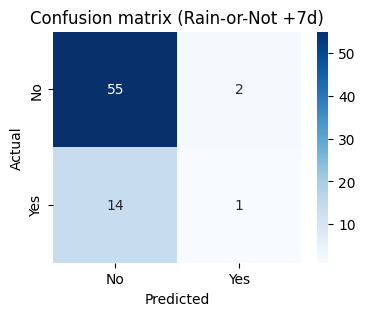

Top classifier features:
 temp_max_mean_7        0.138672
temp_min_mean_7        0.138543
dayofyear_cos          0.133492
temp_week_range        0.112061
dayofyear_sin          0.101711
precip_recent_mean     0.073822
precip_last_7          0.072966
precip_last_3          0.047040
precip_hours_last_7    0.045986
precip_last_1          0.028932
dtype: float64
Saved classifier to: models/rain_or_not/25506751_rain_model.pkl


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# train classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
clf.fit(X_train_clf, y_train_clf)

# predict
y_pred_clf = clf.predict(X_test_clf)
y_proba_clf = clf.predict_proba(X_test_clf)[:,1]

# metrics
acc = accuracy_score(y_test_clf, y_pred_clf)
auc = roc_auc_score(y_test_clf, y_proba_clf)
print("Classifier Accuracy:", acc)
print("Classifier ROC AUC:", auc)
print("\nClassification report:\n", classification_report(y_test_clf, y_pred_clf))

# confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix (Rain-or-Not +7d)")
plt.show()

# feature importances
fi_clf = pd.Series(clf.feature_importances_, index=X_train_clf.columns).sort_values(ascending=False)
print("Top classifier features:\n", fi_clf.head(10))

# save model
os.makedirs("models/rain_or_not", exist_ok=True)
clf_path = f"models/rain_or_not/25506751_rain_model.pkl"
joblib.dump(clf, clf_path)
print("Saved classifier to:", clf_path)


# H.2 Train & Evaluate Regression (Experiment 2 — Precipitation next 3 days)

In [36]:
%pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


Regression MAE: 4.395943749999999
Regression RMSE: 6.710765296317324
Regression R2: 0.30953446756834946


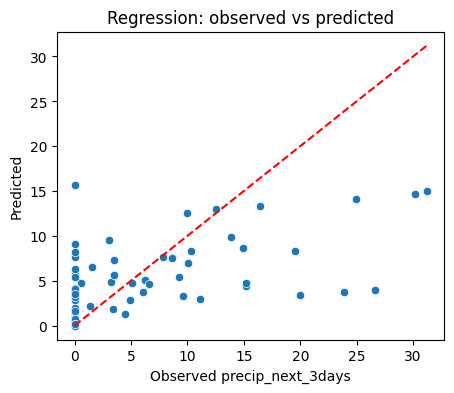

Top regression features:
 dayofyear_cos          0.205735
dayofyear_sin          0.163179
temp_max_mean_7        0.153528
temp_min_mean_7        0.126176
temp_week_range        0.069940
precip_last_7          0.064602
precip_last_3          0.062599
precip_recent_mean     0.052427
precip_hours_last_7    0.029102
precip_last_1          0.020364
dtype: float64
Saved regressor to: models/precipitation_fall/25506751_precip_model.pkl


In [37]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
reg.fit(X_train_reg, y_train_reg)

y_pred_reg = reg.predict(X_test_reg)

from sklearn.metrics import mean_squared_error
import numpy as np

mae  = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))   # <-- change here
r2   = r2_score(y_test_reg, y_pred_reg)

print("Regression MAE:", mae)
print("Regression RMSE:", rmse)
print("Regression R2:",  r2)


# scatter observed vs predicted
plt.figure(figsize=(5,4))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.xlabel("Observed precip_next_3days")
plt.ylabel("Predicted")
plt.title("Regression: observed vs predicted")
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], color="red", linestyle="--")
plt.show()

# top features
fi_reg = pd.Series(reg.feature_importances_, index=X_train_reg.columns).sort_values(ascending=False)
print("Top regression features:\n", fi_reg.head(10))

# save regressor
os.makedirs("models/precipitation_fall", exist_ok=True)
reg_path = f"models/precipitation_fall/25506751_precip_model.pkl"
joblib.dump(reg, reg_path)
print("Saved regressor to:", reg_path)


# H.3 Save prepared datasets (train/test)

In [38]:
os.makedirs("data/processed", exist_ok=True)

# combine features + target for saving
train_clf = X_train_clf.copy(); train_clf["will_rain_plus7"] = y_train_clf
test_clf = X_test_clf.copy(); test_clf["will_rain_plus7"] = y_test_clf

train_reg = X_train_reg.copy(); train_reg["precip_next_3days"] = y_train_reg
test_reg = X_test_reg.copy(); test_reg["precip_next_3days"] = y_test_reg

train_clf.to_csv("data/processed/25506751_train_clf.csv", index=False)
test_clf.to_csv("data/processed/25506751_test_clf.csv", index=False)
train_reg.to_csv("data/processed/25506751_train_reg.csv", index=False)
test_reg.to_csv("data/processed/25506751_test_reg.csv", index=False)

print("Saved processed train/test CSVs to data/processed/")


Saved processed train/test CSVs to data/processed/


# H. Project Outcomes

Summary:
- Classification (will_rain_plus7): A baseline RandomForest with class balancing trained and evaluated. Key metrics printed above (Accuracy / ROC AUC). Feature importance indicates which predictors are most influential.
- Regression (precip_next_3days): RandomForest regressor baseline trained and evaluated. MAE/RMSE/R² reported. Regression is typically harder due to skew and extreme precipitation values — consider log-transforming target or modeling extremes separately.

Next steps / Recommendations:
1. Cross-validate hyperparameters (GridSearchCV or RandomizedSearchCV) for both models.
2. Try specialized models for extreme precipitation (e.g., quantile regression, separate model/classifier for heavy-rain days).
3. Add more engineered features (lagged series beyond 7 days, humidity/wind if available).
4. Calibrate classifier probabilities if using for production alerts.
5. Package model + preprocessing pipeline (scaler/encoders) to ensure reproducibility at inference.
